## Managing Geometry Properties of Imported Networks

In [1]:
import scipy as sp
import openpnm as op
ws = op.Workspace()
ws.settings['loglevel'] = 40  # Supress warnings, but see error messages

Let's start by generating a random network using the Delaunay class

In [2]:
pn = op.network.Delaunay(shape=[1, 1, 0], num_points=100)

This network generator adds nicely defined boundary pores around the edges/faces of the network.  Let's remove these for the sake of this example:

In [3]:
op.topotools.trim(network=pn, pores=pn.pores('boundary'))

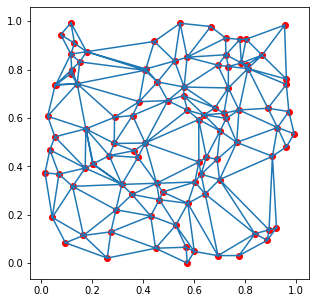

In [4]:
fig = op.topotools.plot_coordinates(network=pn, c='r')
fig = op.topotools.plot_connections(network=pn, fig=fig)
fig.set_size_inches((5, 5))

This network does not have any geometrical properties on it when generated.  To mimic the situation of an imported network, let's manually enter some values for ``'pore.diameter'``.  We'll just assign random numbers to generate the point:

In [5]:
pn['pore.diameter'] = sp.rand(pn.Np)

Now when we ``print`` the network we'll see all the topological data ('pore.coords' and 'throat.conns'), all the labels that were added by the generator (e.g. 'pore.left'), as well as the new geometry info we just added ('pore.diameter'):

In [6]:
print(pn)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
openpnm.network.Delaunay : net_01
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
#     Properties                                    Valid Values
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
1     pore.coords                                     100 / 100  
2     pore.diameter                                   100 / 100  
3     throat.conns                                    264 / 264  
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
#     Labels                                        Assigned Locations
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
1     pore.all                                      100       
2     pore.back                                     0         
3     pore.bottom                                   100       
4     pore.boundary                             

OpenPNM was designed to work by assigning geomtrical information to **Geometry** objects.  The presence of 'pore.diameter' on the network can be a problem in some cases.  For instance, let's add some boundary pores to the left edge:

In [7]:
Ps = pn['pore.surface']*(pn['pore.coords'][:, 0] < 0.1)
Ps = pn.toindices(Ps)
op.topotools.add_boundary_pores(network=pn, pores=Ps, 
                                move_to=[0, None, None], 
                                apply_label='left')

Visualizing this networks shows the newl added pores where we intended:

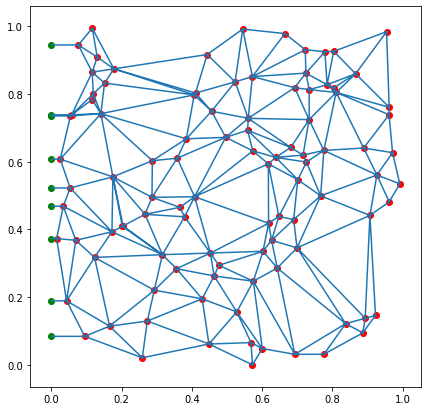

In [8]:
fig = op.topotools.plot_coordinates(network=pn, pores=pn.pores('left', mode='not'), c='r')
fig = op.topotools.plot_coordinates(network=pn, pores=pn.pores('left'), c='g', fig=fig)
fig = op.topotools.plot_connections(network=pn, fig=fig)
fig.set_size_inches((7, 7))

Now we have internal pores (red) and boundary pores (gree).  We would like to assign geometrical information to the boundary pores that we just created.  This is typically done by creating a **Geometry** object, then either assigning numerical values or attaching a pore-scale model that calculates the values.  The problem is that OpenPNM prevents you from having 'pore.diameter' on the network AND a geometry object at the same time. 

In [9]:
Ps = pn.pores('left')
Ts = pn.find_neighbor_throats(pores=Ps)
geo_bndry = op.geometry.GenericGeometry(network=pn, pores=Ps, throats=Ts)

Now we we try to assign 'pore.volume', we'll get the following exception (The "try-except" structure is used for the purpose of this notebook example, but is not needed in an actual script):

In [11]:
try:
    geo_bndry['pore.diameter'] = 0
except Exception as e:
    print(e)

Cannot create pore.diameter when pore.diameter is already defined on the full domain


The solution to this is to remove the geometrical information from the network and place it on it's own geometry.  In this example it is easy to transfer the 'pore.diameter' array, but in the case of a real extracted network there could be quite a few arrays to move.  OpenPNM has a facility for doing this, which will be introduced below.  But first let's look at the basic idea.

First create a new geometry object for the internal pores:

In [12]:
Ps = pn.pores('left', mode='nor')  # Select all pores except those labelled left
Ts = pn.find_neighbor_throats(pores=Ps, mode='xnor')  # Find throats shared by all Ps only
geo_int = op.geometry.GenericGeometry(network=pn, pores=Ps, throats=Ts)

One issue we need to address is that ``geo_int`` does not apply to all the pores, yet the 'pore.diameter' array, being a network array, does.  So we must first extract the array, then index into only the desired locations.

In [13]:
arr = pn.pop('pore.diameter')
Ps = pn.pores(geo_int.name)
geo_int['pore.diameter'] = arr[Ps]

In [14]:
geo_bndry['pore.diameter'] = 0

## Using the Imported Geometry Class
The above was a manual demonstration of the process.  OpenPNM includes a class that automates this: ``openpnm.geometry.Imported``.  To illustrate, let's create a network and add a geometric properties again.

In [15]:
pn = op.network.Delaunay(shape=[1, 1, 0], num_points=100)
pn['pore.diameter'] = sp.rand(pn.Np)

Here we pass the network to the ``Imported`` geometry class.  This class literally removes all numerical data from the network to itself.  Everything is moved except topological info ('pore.coords' and 'throat.conns') and labels ('pore.left').

In [16]:
geo = op.geometry.Imported(network=pn)

Printing ``geo`` reveals that the 'pore.diameter' array has been transferred from the network automatically:

In [17]:
print(geo)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
openpnm.geometry.Imported : geo_01
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
#     Properties                                    Valid Values
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
1     pore.diameter                                   132 / 132  
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
#     Labels                                        Assigned Locations
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
1     pore.all                                      132       
2     throat.all                                    301       
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


Now that the geometrical information is properly assigned to a geometry object, we can now use OpenPNM as intended.  Let's add a single new pore to this network.

In [19]:
op.topotools.extend(network=pn, pore_coords = [[1.2, 1.2, 0]], labels='new')

The new pore can clearly be seen outside the top-right corner of the domain.

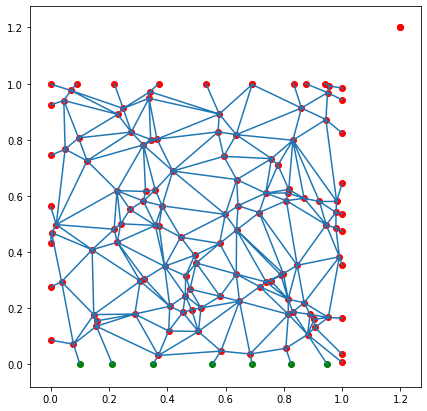

In [21]:
fig = op.topotools.plot_coordinates(network=pn, pores=pn.pores('left', mode='not'), c='r')
fig = op.topotools.plot_coordinates(network=pn, pores=pn.pores('left'), c='g', fig=fig)
fig = op.topotools.plot_connections(network=pn, fig=fig)
fig.set_size_inches((7, 7))

We can now create a geometry just for this single pore and we will be free to add any properties we wish:

In [22]:
geo2 = op.geometry.GenericGeometry(network=pn, pores=pn.pores('new'))
geo2['pore.diameter'] = 2.0

In [23]:
print(geo2)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
openpnm.geometry.GenericGeometry : geo_02
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
#     Properties                                    Valid Values
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
1     pore.diameter                                     2 / 2    
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
#     Labels                                        Assigned Locations
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
1     pore.all                                      2         
2     throat.all                                    0         
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
